In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))])

batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
import torch
from torchvision import datasets, transforms

# Load CIFAR-10 dataset without any normalization
transform = transforms.Compose([transforms.ToTensor()])
cifar10 = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
loader = torch.utils.data.DataLoader(cifar10, batch_size=5000, shuffle=False, num_workers=2)

# Initialize variables for mean and std calculation
mean = 0.0
std = 0.0
total_images = 0

for images, _ in loader:
    batch_samples = images.size(0)  # Number of images in batch
    images = images.view(batch_samples, images.size(1), -1)  # Flatten the images
    mean += images.mean(2).sum(0)  # Sum the means of each channel
    std += images.std(2).sum(0)    # Sum the std devs of each channel
    total_images += batch_samples

mean /= total_images
std /= total_images

print(f"Mean: {mean}")
print(f"Standard Deviation: {std}")


Files already downloaded and verified


KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


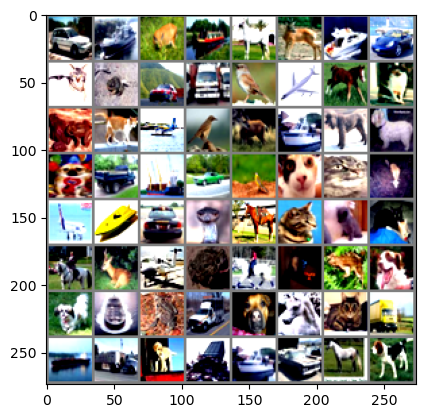

car   ship  deer  ship  horse deer  ship  car   cat   frog  car   truck bird  plane horse cat   frog  cat   plane bird  deer  ship  dog   dog   dog   truck ship  car   bird  cat   cat   deer  plane ship  car   bird  horse cat   cat   cat   horse deer  plane frog  horse cat   frog  dog   dog   ship  frog  truck dog   horse cat   truck ship  truck dog   truck ship  car   horse dog  


In [ ]:


# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [4]:
epoch=15

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)


Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [1]:
def train(net, trainloader, optimizer, criterion, device):
    net.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Accumulate loss
        running_loss += loss.item()

    # Calculate average training loss for the epoch
    avg_train_loss = running_loss / len(trainloader)
    return avg_train_loss


def test(net, testloader, criterion, device):
    net.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            # Calculate loss
            outputs = net(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate average test loss
    avg_test_loss = test_loss / len(testloader)
    accuracy = 100 * correct / total
    print(f'Accuracy of the network on the test images: {accuracy:.2f}%')
    print(f'Average Test Loss: {avg_test_loss:.4f}')
    return avg_test_loss, accuracy


import matplotlib.pyplot as plt
import torch

def class_accuracy(net, testloader, classes):
    accuracies = []
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    # No gradients needed
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            _, predictions = torch.max(outputs, 1)

            # Collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label.item() == prediction.item():  # Convert to Python integers for comparison
                    correct_pred[classes[label.item()]] += 1
                total_pred[classes[label.item()]] += 1

    # Print accuracy for each class
    for classname, correct_count in correct_pred.items():
        total_count = total_pred[classname]
        if total_count > 0:  # Avoid division by zero
            accuracy = 100 * float(correct_count) / total_count
        else:
            accuracy = 0.0  # No samples in this class
        accuracies.append(accuracy)
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

    return accuracies  # Return the accuracies list

def plot_class_accuracy(net, testloader, classes):
    accuracies = class_accuracy(net, testloader, classes)  # Pass classes argument
    plt.figure(figsize=(10, 6))
    plt.bar(classes, accuracies, color='skyblue')
    plt.xlabel('Class')
    plt.grid()
    plt.ylabel('Accuracy (%)')
    plt.title('Class-wise Accuracy')
    plt.ylim(0, 100)  # Set y-axis limits from 0 to 100 to represent percentage
    plt.xticks(rotation=45)
    plt.show()

import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_class_accuracy_with_confusion_matrix(net, testloader, classes):
    # Get class-wise accuracy
    accuracies = class_accuracy(net, testloader, classes)
    
    # Initialize empty lists for predictions and true labels for confusion matrix
    all_preds = []
    all_labels = []

    # Accumulate predictions and labels for the entire dataset
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            _, predictions = torch.max(outputs, 1)
            
            # Append predictions and labels to lists
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute the confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot class-wise accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.bar(classes, accuracies, color='skyblue')
    plt.xlabel('Class')
    plt.ylabel('Accuracy (%)')
    plt.title('Class-wise Accuracy')
    plt.ylim(0, 100)
    plt.xticks(rotation=45)
    plt.grid()

    # Plot confusion matrix as a heatmap
    plt.subplot(1, 2, 2)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()


In [5]:
import os
import time
import matplotlib.pyplot as plt

device = 'cuda'

def plot_training(net, trainloader, testloader, epochs, optimizer, criterion, scheduler, title):
    running_train_loss = []
    running_test_loss = []
    running_accuracy = []
    execution_time = 0

    # Loop through each epoch
    for e in range(epochs):
        start = time.time()
        
        # Print current epoch number
        print(f"Epoch {e + 1}/{epochs}")
        
        # Training and testing for the current epoch
        train_loss = train(net=net, trainloader=trainloader, optimizer=optimizer, criterion=criterion, device=device)
        test_loss, accuracy = test(net=net, testloader=testloader, criterion=criterion, device=device)
        
        # Update lists for plotting
        running_train_loss.append(train_loss)
        running_test_loss.append(test_loss)
        running_accuracy.append(accuracy)
        
        # Step the scheduler at the end of each epoch
        if scheduler is not None:
            scheduler.step()

        end = time.time()
        epoch_time = end - start
        execution_time += epoch_time
        
        # Print metrics for the current epoch
        print(f"Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%, Time: {epoch_time:.2f}s")

    # Create directory if it doesn't exist
    save_dir = 'plot_assignment2'
    os.makedirs(save_dir, exist_ok=True)

    # Plot Training and Test Loss
    plt.figure(figsize=(10, 5))
    plt.plot(running_train_loss, label='Training Loss', color='blue', linestyle='--')
    plt.plot(running_test_loss, label='Test Loss', color='red')
    plt.title("Training and Test Loss over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    
    # Save the loss plot with the specified title
    loss_filename = os.path.join(save_dir, f"{title}_loss.png")
    plt.savefig(loss_filename)
    
    # Show the loss plot
    plt.show()  # Display the plot interactively
    plt.close()  # Close the figure to free up memory

    # Plot Test Accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(running_accuracy, label='Test Accuracy', color='green')
    plt.title("Test Accuracy over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.grid()
    
    # Save the accuracy plot with the specified title
    accuracy_filename = os.path.join(save_dir, f"{title}_accuracy.png")
    plt.savefig(accuracy_filename)

    # Show the accuracy plot
    plt.show()  # Display the plot interactively
    plt.close()  # Close the figure to free up memory

    print(f"Plots saved as '{loss_filename}' and '{accuracy_filename}'.")

    # Final summary
    print("\nTraining Complete!")
    print(f"Total Training Time: {execution_time:.2f} seconds")
    print(f"Minimum Training Loss: {min(running_train_loss):.4f}")
    print(f"Minimum Test Loss: {min(running_test_loss):.4f}")
    print(f"Highest Test Accuracy: {max(running_accuracy):.2f}%")
    
    return running_train_loss, running_test_loss, running_accuracy, execution_time


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


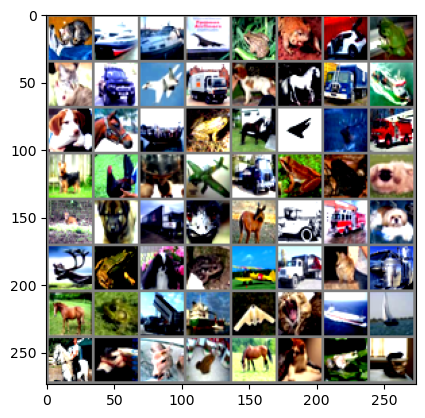

GroundTruth:  cat   ship  ship  plane


In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

# Baseline

Epoch 1/15
Accuracy of the network on the test images: 47.12%
Average Test Loss: 1.4559
Train Loss: 1.7445, Test Loss: 1.4559, Accuracy: 47.12%, Time: 15.24s
Epoch 2/15
Accuracy of the network on the test images: 54.63%
Average Test Loss: 1.2708
Train Loss: 1.3614, Test Loss: 1.2708, Accuracy: 54.63%, Time: 14.41s
Epoch 3/15
Accuracy of the network on the test images: 58.62%
Average Test Loss: 1.1849
Train Loss: 1.2127, Test Loss: 1.1849, Accuracy: 58.62%, Time: 14.54s
Epoch 4/15
Accuracy of the network on the test images: 59.53%
Average Test Loss: 1.1565
Train Loss: 1.1203, Test Loss: 1.1565, Accuracy: 59.53%, Time: 14.40s
Epoch 5/15
Accuracy of the network on the test images: 60.05%
Average Test Loss: 1.1366
Train Loss: 1.0582, Test Loss: 1.1366, Accuracy: 60.05%, Time: 14.73s
Epoch 6/15
Accuracy of the network on the test images: 60.87%
Average Test Loss: 1.1267
Train Loss: 0.9935, Test Loss: 1.1267, Accuracy: 60.87%, Time: 14.57s
Epoch 7/15
Accuracy of the network on the test image

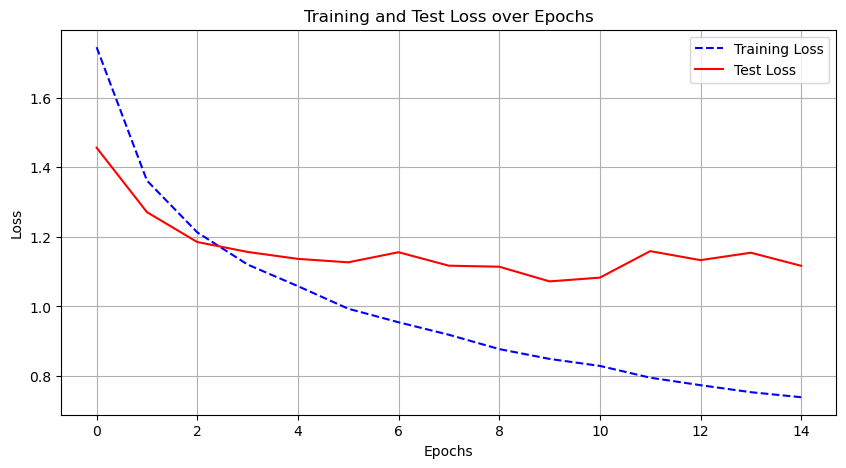

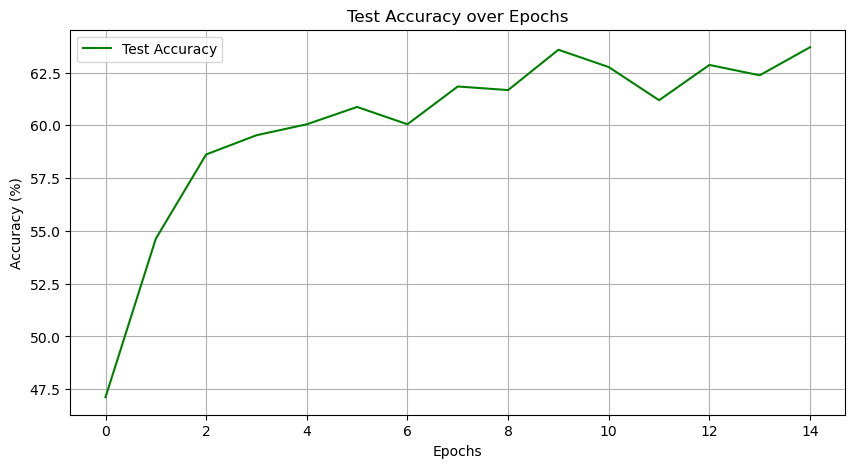

Plots saved as 'plot_assignment2\Baseline CNN_loss.png' and 'plot_assignment2\Baseline CNN_accuracy.png'.

Training Complete!
Total Training Time: 213.37 seconds
Minimum Training Loss: 0.7393
Minimum Test Loss: 1.0719
Highest Test Accuracy: 63.70%
Accuracy for class: plane is 74.7 %
Accuracy for class: car   is 76.8 %
Accuracy for class: bird  is 52.1 %
Accuracy for class: cat   is 38.8 %
Accuracy for class: deer  is 59.1 %
Accuracy for class: dog   is 46.6 %
Accuracy for class: frog  is 71.0 %
Accuracy for class: horse is 71.6 %
Accuracy for class: ship  is 71.5 %
Accuracy for class: truck is 74.8 %


In [ ]:
net = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
plot_training(net, trainloader=trainloader, testloader=testloader, epochs=epoch, optimizer=optimizer, criterion=criterion,title='Baseline CNN', scheduler=None)
class_accuracy(net, testloader)

# Baseline + Multistep

Epoch 1/15
Accuracy of the network on the test images: 46.44%
Average Test Loss: 1.4707
Train Loss: 1.7351, Test Loss: 1.4707, Accuracy: 46.44%, Time: 14.45s
Epoch 2/15
Accuracy of the network on the test images: 54.97%
Average Test Loss: 1.2793
Train Loss: 1.3650, Test Loss: 1.2793, Accuracy: 54.97%, Time: 13.44s
Epoch 3/15
Accuracy of the network on the test images: 55.78%
Average Test Loss: 1.2322
Train Loss: 1.2163, Test Loss: 1.2322, Accuracy: 55.78%, Time: 13.43s
Epoch 4/15
Accuracy of the network on the test images: 60.28%
Average Test Loss: 1.1192
Train Loss: 1.1246, Test Loss: 1.1192, Accuracy: 60.28%, Time: 13.56s
Epoch 5/15
Accuracy of the network on the test images: 61.55%
Average Test Loss: 1.1202
Train Loss: 1.0531, Test Loss: 1.1202, Accuracy: 61.55%, Time: 13.57s
Epoch 6/15
Accuracy of the network on the test images: 65.26%
Average Test Loss: 1.0054
Train Loss: 0.8579, Test Loss: 1.0054, Accuracy: 65.26%, Time: 13.61s
Epoch 7/15
Accuracy of the network on the test image

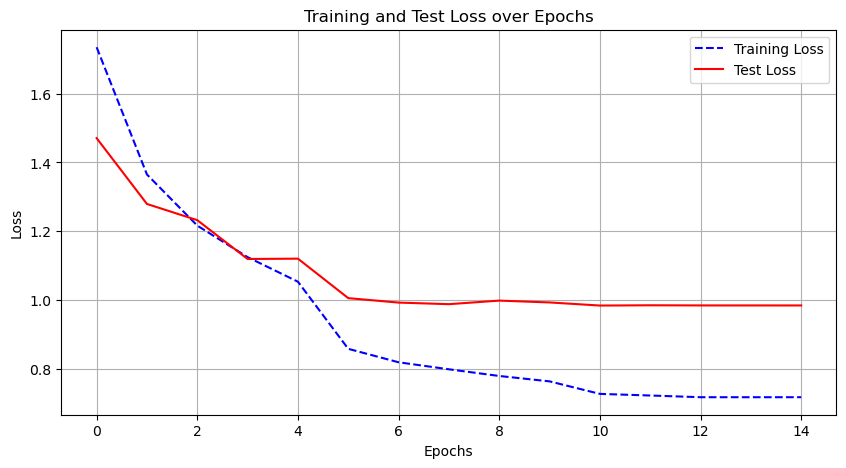

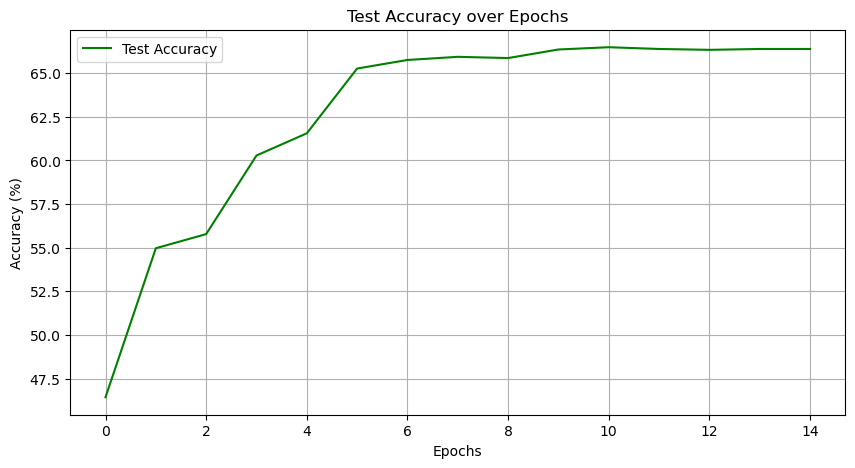

Plots saved as 'plot_assignment2\Baseline CNN MiltistepLR_loss.png' and 'plot_assignment2\Baseline CNN MiltistepLR_accuracy.png'.

Training Complete!
Total Training Time: 204.66 seconds
Minimum Training Loss: 0.7172
Minimum Test Loss: 0.9838
Highest Test Accuracy: 66.48%
Accuracy for class: plane is 70.9 %
Accuracy for class: car   is 79.8 %
Accuracy for class: bird  is 53.1 %
Accuracy for class: cat   is 46.9 %
Accuracy for class: deer  is 59.8 %
Accuracy for class: dog   is 53.7 %
Accuracy for class: frog  is 75.8 %
Accuracy for class: horse is 72.1 %
Accuracy for class: ship  is 77.5 %
Accuracy for class: truck is 74.2 %


In [ ]:
net = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10, 12], gamma=0.1)
plot_training(net, trainloader=trainloader, testloader=testloader, epochs=15, optimizer=optimizer, criterion=criterion,title='Baseline CNN MiltistepLR',scheduler=scheduler)
class_accuracy(net, testloader)

# Baseline + CosineAnnealing

Epoch 1/15
Accuracy of the network on the test images: 46.74%
Average Test Loss: 1.4755
Train Loss: 1.7934, Test Loss: 1.4755, Accuracy: 46.74%, Time: 15.13s
Epoch 2/15
Accuracy of the network on the test images: 52.25%
Average Test Loss: 1.3312
Train Loss: 1.3866, Test Loss: 1.3312, Accuracy: 52.25%, Time: 14.31s
Epoch 3/15
Accuracy of the network on the test images: 57.37%
Average Test Loss: 1.2052
Train Loss: 1.2349, Test Loss: 1.2052, Accuracy: 57.37%, Time: 15.14s
Epoch 4/15
Accuracy of the network on the test images: 58.06%
Average Test Loss: 1.1744
Train Loss: 1.1255, Test Loss: 1.1744, Accuracy: 58.06%, Time: 14.28s
Epoch 5/15
Accuracy of the network on the test images: 59.56%
Average Test Loss: 1.1618
Train Loss: 1.0436, Test Loss: 1.1618, Accuracy: 59.56%, Time: 15.52s
Epoch 6/15
Accuracy of the network on the test images: 63.19%
Average Test Loss: 1.0555
Train Loss: 0.9818, Test Loss: 1.0555, Accuracy: 63.19%, Time: 14.49s
Epoch 7/15
Accuracy of the network on the test image

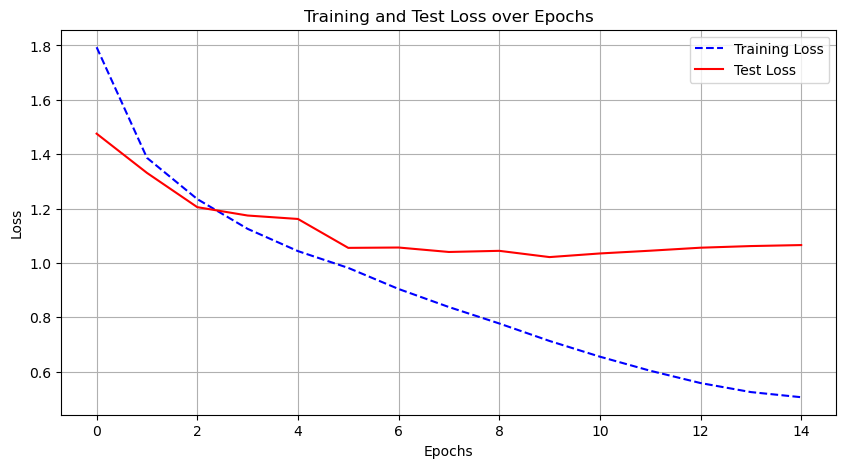

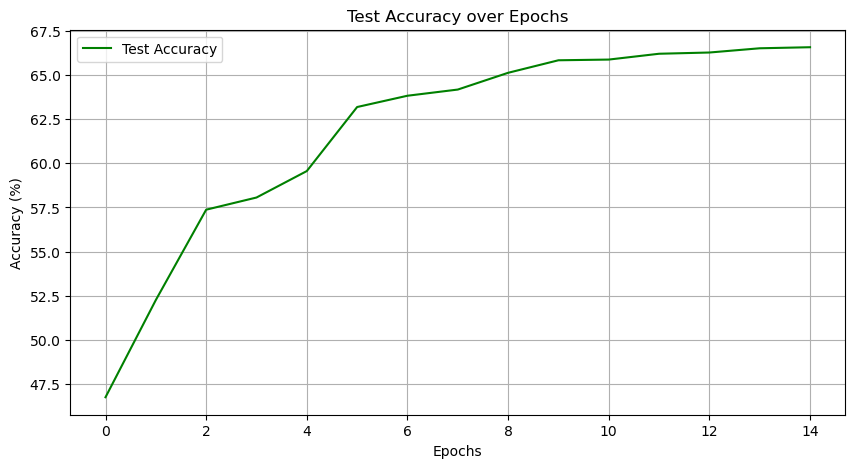

Plots saved as 'plot_assignment2\Baseline CNN CosineAnnealingLR_loss.png' and 'plot_assignment2\Baseline CNN CosineAnnealingLR_accuracy.png'.

Training Complete!
Total Training Time: 219.40 seconds
Minimum Training Loss: 0.5063
Minimum Test Loss: 1.0216
Highest Test Accuracy: 66.58%
Accuracy for class: plane is 73.3 %
Accuracy for class: car   is 78.6 %
Accuracy for class: bird  is 56.0 %
Accuracy for class: cat   is 46.4 %
Accuracy for class: deer  is 61.7 %
Accuracy for class: dog   is 55.0 %
Accuracy for class: frog  is 72.9 %
Accuracy for class: horse is 68.9 %
Accuracy for class: ship  is 78.0 %
Accuracy for class: truck is 75.0 %


In [ ]:
net = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epoch)
plot_training(net, trainloader=trainloader, testloader=testloader, epochs=15, optimizer=optimizer, criterion=criterion,title='Baseline CNN CosineAnnealingLR',
              scheduler=scheduler)
class_accuracy(net, testloader)

# Resnet Pretrained

c:\Users\sangi\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sangi\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/15
Accuracy of the network on the test images: 73.70%
Average Test Loss: 0.7676
Train Loss: 1.2827, Test Loss: 0.7676, Accuracy: 73.70%, Time: 20.52s
Epoch 2/15
Accuracy of the network on the test images: 77.35%
Average Test Loss: 0.6635
Train Loss: 0.6878, Test Loss: 0.6635, Accuracy: 77.35%, Time: 19.66s
Epoch 3/15
Accuracy of the network on the test images: 79.89%
Average Test Loss: 0.6041
Train Loss: 0.5258, Test Loss: 0.6041, Accuracy: 79.89%, Time: 19.90s
Epoch 4/15
Accuracy of the network on the test images: 80.33%
Average Test Loss: 0.5968
Train Loss: 0.4177, Test Loss: 0.5968, Accuracy: 80.33%, Time: 19.83s
Epoch 5/15
Accuracy of the network on the test images: 80.73%
Average Test Loss: 0.5962
Train Loss: 0.3347, Test Loss: 0.5962, Accuracy: 80.73%, Time: 20.01s
Epoch 6/15
Accuracy of the network on the test images: 80.80%
Average Test Loss: 0.6442
Train Loss: 0.2696, Test Loss: 0.6442, Accuracy: 80.80%, Time: 20.29s
Epoch 7/15
Accuracy of the network on the test image

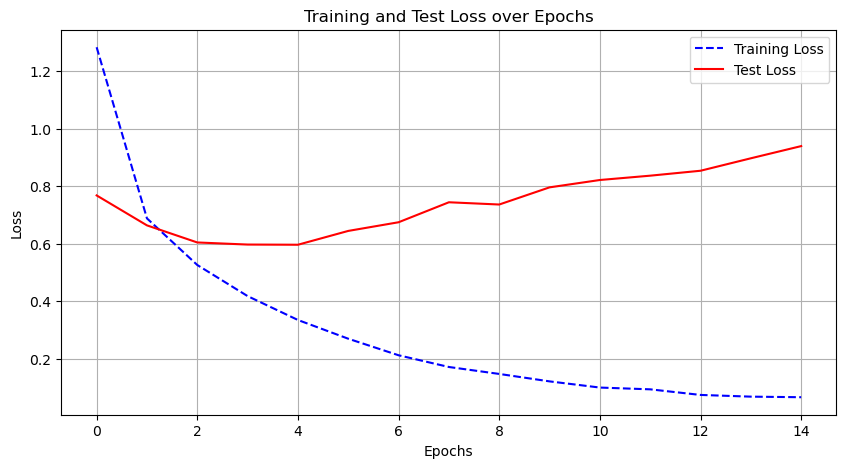

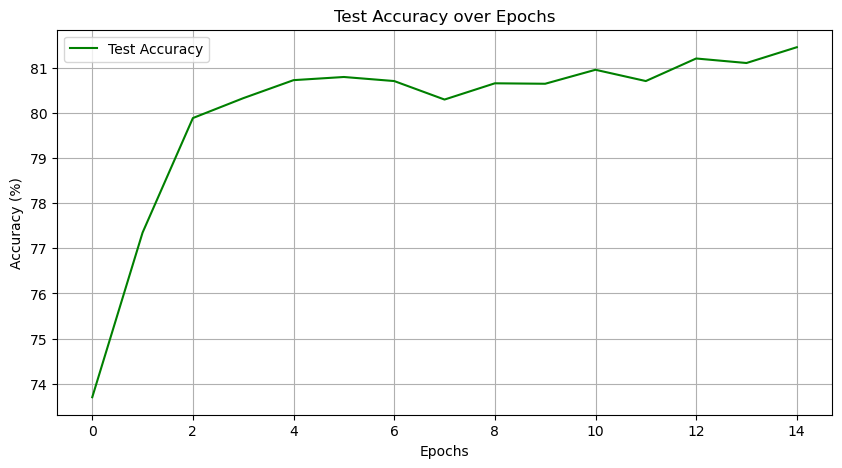

Plots saved as 'plot_assignment2\ResNet18 Fine Tuned_loss.png' and 'plot_assignment2\ResNet18 Fine Tuned_accuracy.png'.

Training Complete!
Total Training Time: 300.29 seconds
Minimum Training Loss: 0.0662
Minimum Test Loss: 0.5962
Highest Test Accuracy: 81.46%
Accuracy for class: plane is 88.9 %
Accuracy for class: car   is 90.4 %
Accuracy for class: bird  is 76.3 %
Accuracy for class: cat   is 62.2 %
Accuracy for class: deer  is 77.3 %
Accuracy for class: dog   is 72.3 %
Accuracy for class: frog  is 85.7 %
Accuracy for class: horse is 83.2 %
Accuracy for class: ship  is 89.6 %
Accuracy for class: truck is 88.7 %


In [ ]:
import torchvision.models as models

net = models.resnet18(pretrained=True)

net = net.to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
plot_training(net, trainloader=trainloader, testloader=testloader, epochs=15, optimizer=optimizer, criterion=criterion,title='ResNet18 Fine Tuned',scheduler=None)
class_accuracy(net, testloader)

# Resnet 1-shot

In [ ]:
import torchvision.models as models

net = models.resnet18(pretrained=True)

net = net.to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
class_accuracy(net, testloader)

c:\Users\sangi\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sangi\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Accuracy for class: plane is 0.0 %
Accuracy for class: car   is 0.3 %
Accuracy for class: bird  is 0.0 %
Accuracy for class: cat   is 0.0 %
Accuracy for class: deer  is 0.1 %
Accuracy for class: dog   is 0.4 %
Accuracy for class: frog  is 0.0 %
Accuracy for class: horse is 0.1 %
Accuracy for class: ship  is 0.0 %
Accuracy for class: truck is 0.0 %


# Resnet18 fine tuned layer4 & fc

Epoch 1/15
Accuracy of the network on the test images: 61.93%
Average Test Loss: 1.0849
Train Loss: 1.3308, Test Loss: 1.0849, Accuracy: 61.93%, Time: 17.21s
Epoch 2/15
Accuracy of the network on the test images: 65.11%
Average Test Loss: 1.0035
Train Loss: 0.9881, Test Loss: 1.0035, Accuracy: 65.11%, Time: 17.20s
Epoch 3/15
Accuracy of the network on the test images: 66.10%
Average Test Loss: 0.9727
Train Loss: 0.8447, Test Loss: 0.9727, Accuracy: 66.10%, Time: 17.39s
Epoch 4/15
Accuracy of the network on the test images: 66.65%
Average Test Loss: 0.9892
Train Loss: 0.7366, Test Loss: 0.9892, Accuracy: 66.65%, Time: 17.85s
Epoch 5/15
Accuracy of the network on the test images: 67.32%
Average Test Loss: 1.0062
Train Loss: 0.6413, Test Loss: 1.0062, Accuracy: 67.32%, Time: 17.20s
Epoch 6/15
Accuracy of the network on the test images: 67.04%
Average Test Loss: 1.0238
Train Loss: 0.5668, Test Loss: 1.0238, Accuracy: 67.04%, Time: 17.57s
Epoch 7/15
Accuracy of the network on the test image

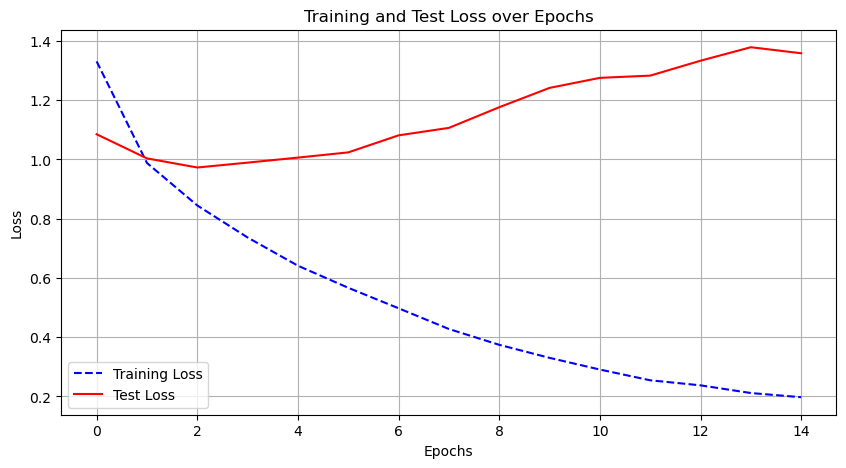

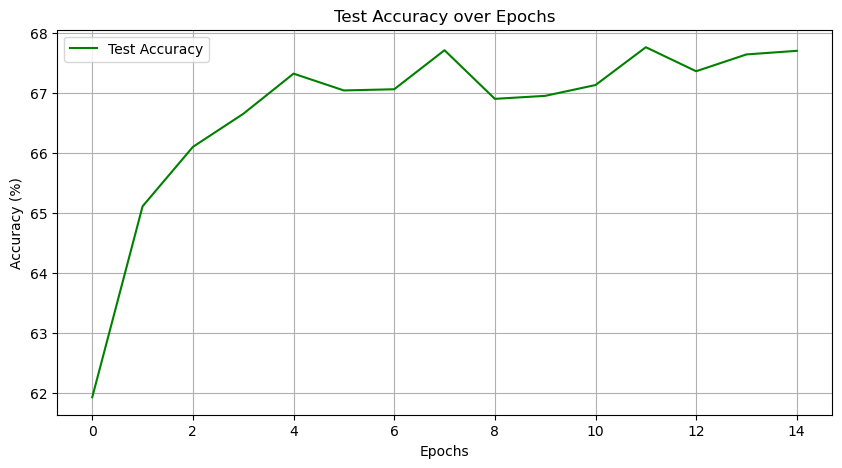

Plots saved as 'plot_assignment2\ResNet18 Fine Tuned L4 & FC_loss.png' and 'plot_assignment2\ResNet18 Fine Tuned L4 & FC_accuracy.png'.

Training Complete!
Total Training Time: 256.33 seconds
Minimum Training Loss: 0.1975
Minimum Test Loss: 0.9727
Highest Test Accuracy: 67.76%
Accuracy for class: plane is 70.3 %
Accuracy for class: car   is 75.1 %
Accuracy for class: bird  is 58.1 %
Accuracy for class: cat   is 51.1 %
Accuracy for class: deer  is 61.4 %
Accuracy for class: dog   is 59.7 %
Accuracy for class: frog  is 76.0 %
Accuracy for class: horse is 74.6 %
Accuracy for class: ship  is 75.8 %
Accuracy for class: truck is 74.9 %


In [ ]:
import torchvision.models as models

net = models.resnet18(pretrained=True)
for param in net.parameters():
    param.requires_grad = False
net.fc = nn.Linear(net.fc.in_features, 10)
for param in net.layer4.parameters():
    param.requires_grad = True
net = net.to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
plot_training(net, trainloader=trainloader, testloader=testloader, epochs=15, optimizer=optimizer, criterion=criterion,title='ResNet18 Fine Tuned L4 & FC',scheduler=None)
class_accuracy(net, testloader)

## Exercise 0
Find the correct mean and std of CIFAR10 dataset to normalize data correctly, i.e., to have data with mean 0 and std 1.

### Exercise 1
Try to use a scheduler for the learning rate (https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate).

- What are the differences?
- Does it improves the training convergence/test accuracy?

In [ ]:
""" Example of usage
    >>> scheduler = MultiStepLR(optimizer, milestones=[30,80], gamma=0.1)
    >>> for epoch in range(100):
    >>>     train(...)
    >>>     test(...)
    >>>     scheduler.step()
"""

from torch.optim.lr_scheduler import MultiStepLR


## Exercise 2

Use some data augmentation to reduce overfitting.

All the transformations supported by PyTorch can be found at https://pytorch.org/vision/0.9/transforms.html#compositions-of-transforms

- Which transformations are the most impactfull on the accuracies?

Try to plot the effect of the transformations!

In [ ]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch

transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL Image or numpy.ndarray to tensor
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(5),  # Rotation degrees
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),  # Normalize tensor
])

trainset = datasets.CIFAR10(root='data', train=True, transform=transform, download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)


Files already downloaded and verified


# Baselne Cosine Annealing Augmented

Epoch 1/15
Accuracy of the network on the test images: 43.51%
Average Test Loss: 1.5527
Train Loss: 1.8600, Test Loss: 1.5527, Accuracy: 43.51%, Time: 19.36s
Epoch 2/15
Accuracy of the network on the test images: 49.32%
Average Test Loss: 1.3868
Train Loss: 1.5496, Test Loss: 1.3868, Accuracy: 49.32%, Time: 18.53s
Epoch 3/15
Accuracy of the network on the test images: 54.60%
Average Test Loss: 1.2657
Train Loss: 1.4208, Test Loss: 1.2657, Accuracy: 54.60%, Time: 18.45s
Epoch 4/15
Accuracy of the network on the test images: 56.78%
Average Test Loss: 1.2159
Train Loss: 1.3454, Test Loss: 1.2159, Accuracy: 56.78%, Time: 18.35s
Epoch 5/15
Accuracy of the network on the test images: 59.52%
Average Test Loss: 1.1401
Train Loss: 1.2899, Test Loss: 1.1401, Accuracy: 59.52%, Time: 18.45s
Epoch 6/15
Accuracy of the network on the test images: 59.07%
Average Test Loss: 1.1682
Train Loss: 1.2462, Test Loss: 1.1682, Accuracy: 59.07%, Time: 18.52s
Epoch 7/15
Accuracy of the network on the test image

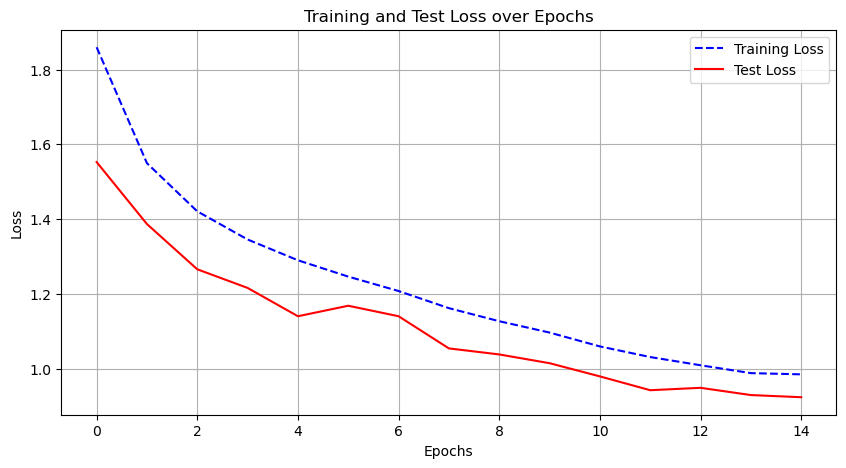

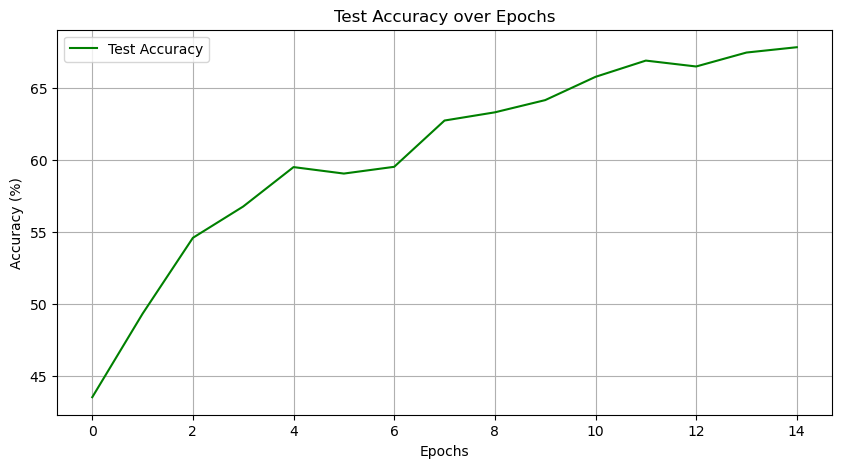

Plots saved as 'plot_assignment2\Baseline Augmented_loss.png' and 'plot_assignment2\Baseline Augmented_accuracy.png'.

Training Complete!
Total Training Time: 280.37 seconds
Minimum Training Loss: 0.9846
Minimum Test Loss: 0.9234
Highest Test Accuracy: 67.86%
Accuracy for class: plane is 74.1 %
Accuracy for class: car   is 82.2 %
Accuracy for class: bird  is 55.9 %
Accuracy for class: cat   is 44.0 %
Accuracy for class: deer  is 60.9 %
Accuracy for class: dog   is 61.0 %
Accuracy for class: frog  is 77.9 %
Accuracy for class: horse is 70.8 %
Accuracy for class: ship  is 76.9 %
Accuracy for class: truck is 74.9 %


In [ ]:
net = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epoch)
plot_training(net, trainloader=trainloader, testloader=testloader, epochs=15, optimizer=optimizer, criterion=criterion,title='Baseline Augmented',scheduler=scheduler)
class_accuracy(net, testloader)

# Baseline with Augmentation with all trasfomrations

Epoch 1/15
Accuracy of the network on the test images: 43.44%
Average Test Loss: 1.5445
Train Loss: 1.8973, Test Loss: 1.5445, Accuracy: 43.44%, Time: 90.78s
Epoch 2/15
Accuracy of the network on the test images: 47.67%
Average Test Loss: 1.4275
Train Loss: 1.6118, Test Loss: 1.4275, Accuracy: 47.67%, Time: 102.52s
Epoch 3/15
Accuracy of the network on the test images: 54.11%
Average Test Loss: 1.2736
Train Loss: 1.4837, Test Loss: 1.2736, Accuracy: 54.11%, Time: 97.22s
Epoch 4/15
Accuracy of the network on the test images: 56.81%
Average Test Loss: 1.2474
Train Loss: 1.4002, Test Loss: 1.2474, Accuracy: 56.81%, Time: 100.49s
Epoch 5/15
Accuracy of the network on the test images: 59.37%
Average Test Loss: 1.1574
Train Loss: 1.3315, Test Loss: 1.1574, Accuracy: 59.37%, Time: 98.47s
Epoch 6/15
Accuracy of the network on the test images: 59.97%
Average Test Loss: 1.1386
Train Loss: 1.2877, Test Loss: 1.1386, Accuracy: 59.97%, Time: 97.15s
Epoch 7/15
Accuracy of the network on the test ima

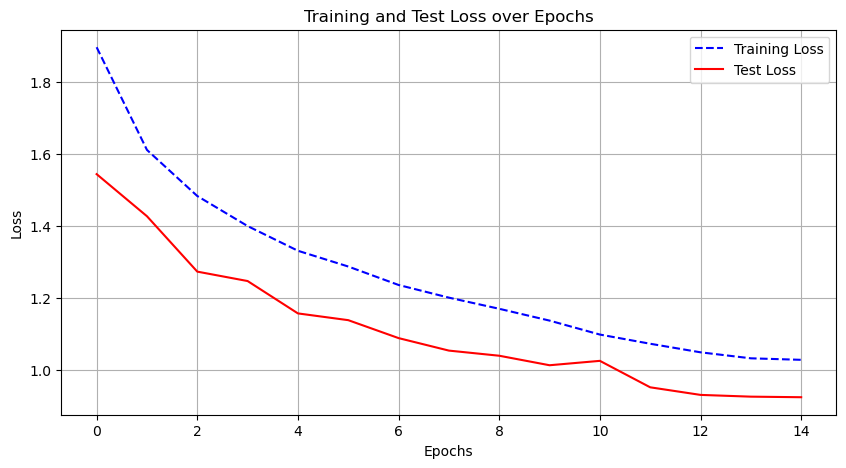

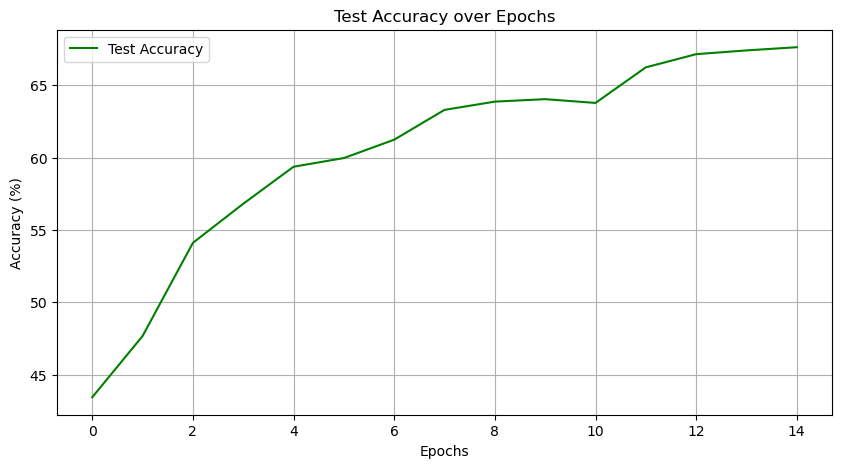

Plots saved as 'plot_assignment2\Baseline Augmented all combos_loss.png' and 'plot_assignment2\Baseline Augmented all combos_accuracy.png'.

Training Complete!
Total Training Time: 1382.75 seconds
Minimum Training Loss: 1.0284
Minimum Test Loss: 0.9245
Highest Test Accuracy: 67.63%
Accuracy for class: plane is 72.0 %
Accuracy for class: car   is 86.1 %
Accuracy for class: bird  is 53.4 %
Accuracy for class: cat   is 46.3 %
Accuracy for class: deer  is 62.3 %
Accuracy for class: dog   is 56.2 %
Accuracy for class: frog  is 74.8 %
Accuracy for class: horse is 74.5 %
Accuracy for class: ship  is 76.1 %
Accuracy for class: truck is 74.6 %


In [ ]:
net = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epoch)
plot_training(net, trainloader=trainloader, testloader=testloader, epochs=15, optimizer=optimizer, criterion=criterion,title='Baseline Augmented all Transforms',scheduler=scheduler)
class_accuracy(net, testloader)

# FC augmented

Epoch 1/15
Accuracy of the network on the test images: 40.25%
Average Test Loss: 1.6777
Train Loss: 1.9179, Test Loss: 1.6777, Accuracy: 40.25%, Time: 91.13s
Epoch 2/15
Accuracy of the network on the test images: 43.24%
Average Test Loss: 1.5917
Train Loss: 1.7352, Test Loss: 1.5917, Accuracy: 43.24%, Time: 88.80s
Epoch 3/15
Accuracy of the network on the test images: 45.42%
Average Test Loss: 1.5172
Train Loss: 1.6673, Test Loss: 1.5172, Accuracy: 45.42%, Time: 88.21s
Epoch 4/15
Accuracy of the network on the test images: 47.51%
Average Test Loss: 1.4715
Train Loss: 1.6217, Test Loss: 1.4715, Accuracy: 47.51%, Time: 88.07s
Epoch 5/15
Accuracy of the network on the test images: 47.85%
Average Test Loss: 1.4528
Train Loss: 1.5849, Test Loss: 1.4528, Accuracy: 47.85%, Time: 88.87s
Epoch 6/15
Accuracy of the network on the test images: 48.62%
Average Test Loss: 1.4267
Train Loss: 1.5569, Test Loss: 1.4267, Accuracy: 48.62%, Time: 87.70s
Epoch 7/15
Accuracy of the network on the test image

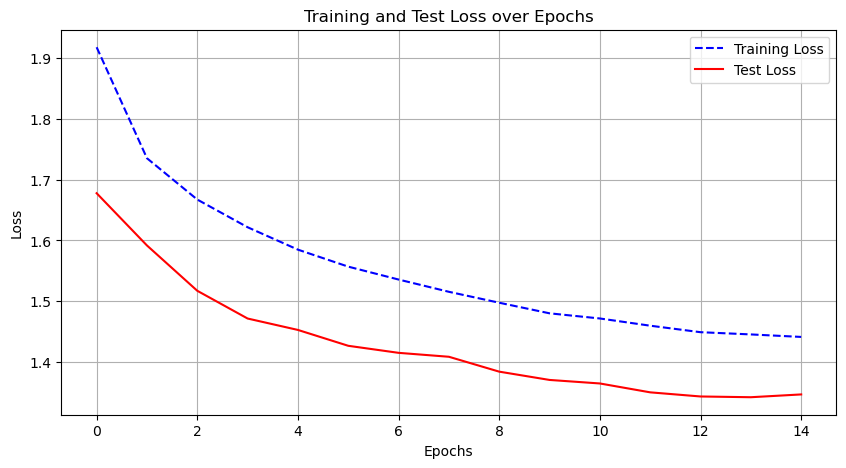

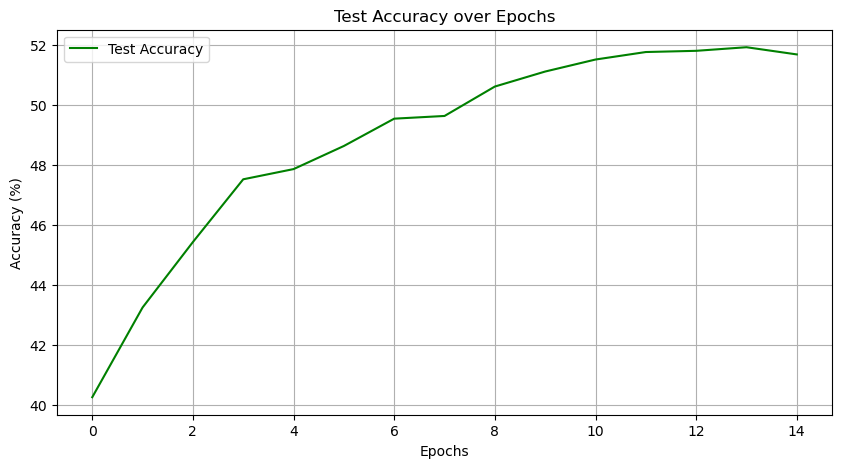

Plots saved as 'plot_assignment2\FC Augmented CosineAnnealing_loss.png' and 'plot_assignment2\FC Augmented CosineAnnealing_accuracy.png'.

Training Complete!
Total Training Time: 1333.23 seconds
Minimum Training Loss: 1.4413
Minimum Test Loss: 1.3421
Highest Test Accuracy: 51.91%
Accuracy for class: plane is 55.9 %
Accuracy for class: car   is 66.5 %
Accuracy for class: bird  is 35.4 %
Accuracy for class: cat   is 30.6 %
Accuracy for class: deer  is 33.3 %
Accuracy for class: dog   is 39.8 %
Accuracy for class: frog  is 65.8 %
Accuracy for class: horse is 64.4 %
Accuracy for class: ship  is 66.5 %
Accuracy for class: truck is 58.5 %


In [ ]:
import torch
import torch.nn as nn

class DeepFCNet5Layers(nn.Module):
    def __init__(self):
        super(DeepFCNet5Layers, self).__init__()
        
        # Define the 5 layers
        self.layers = nn.Sequential(
            nn.Linear(3072, 512),       # Layer 1
            nn.BatchNorm1d(512),
            nn.ReLU(),
            
            nn.Linear(512, 256),        # Layer 2
            nn.BatchNorm1d(256),
            nn.ReLU(),
            
            nn.Linear(256, 128),        # Layer 3
            nn.BatchNorm1d(128),
            nn.ReLU(),
            
            nn.Linear(128, 64),         # Layer 4
            nn.BatchNorm1d(64),
            nn.ReLU(),
            
            nn.Linear(64, 10)           # Output Layer for 10 classes
        )
        
    def forward(self, x):
        # Flatten the 32x32 image to a 1024 vector
        x = x.view(x.size(0), -1)
        x = self.layers(x)
        return x

# Initialize the model and move it to the device
net = DeepFCNet5Layers()
device = torch.device("cuda")
net.to(device)
epoch=15
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epoch)
plot_training(net, trainloader=trainloader, testloader=testloader, epochs=15, optimizer=optimizer, scheduler=scheduler, criterion=criterion,title='FC Augmented CosineAnnealing')
class_accuracy(net, testloader)

# Custon CNN Augmented

Epoch 1/15
Accuracy of the network on the test images: 63.87%
Average Test Loss: 1.0305
Train Loss: 1.3377, Test Loss: 1.0305, Accuracy: 63.87%, Time: 20.92s
Epoch 2/15
Accuracy of the network on the test images: 72.15%
Average Test Loss: 0.7971
Train Loss: 0.9161, Test Loss: 0.7971, Accuracy: 72.15%, Time: 18.89s
Epoch 3/15
Accuracy of the network on the test images: 75.80%
Average Test Loss: 0.7019
Train Loss: 0.7480, Test Loss: 0.7019, Accuracy: 75.80%, Time: 18.72s
Epoch 4/15
Accuracy of the network on the test images: 78.20%
Average Test Loss: 0.6386
Train Loss: 0.6337, Test Loss: 0.6386, Accuracy: 78.20%, Time: 18.57s
Epoch 5/15
Accuracy of the network on the test images: 79.07%
Average Test Loss: 0.6236
Train Loss: 0.5357, Test Loss: 0.6236, Accuracy: 79.07%, Time: 18.88s
Epoch 6/15
Accuracy of the network on the test images: 81.05%
Average Test Loss: 0.5541
Train Loss: 0.4552, Test Loss: 0.5541, Accuracy: 81.05%, Time: 18.90s
Epoch 7/15
Accuracy of the network on the test image

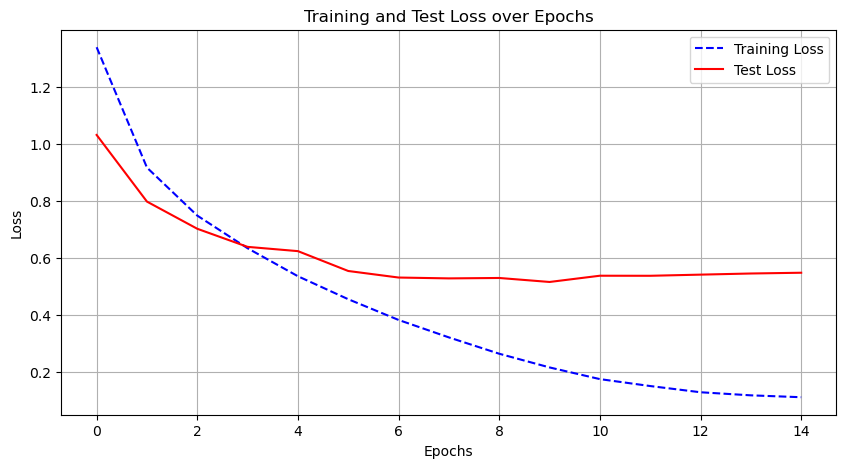

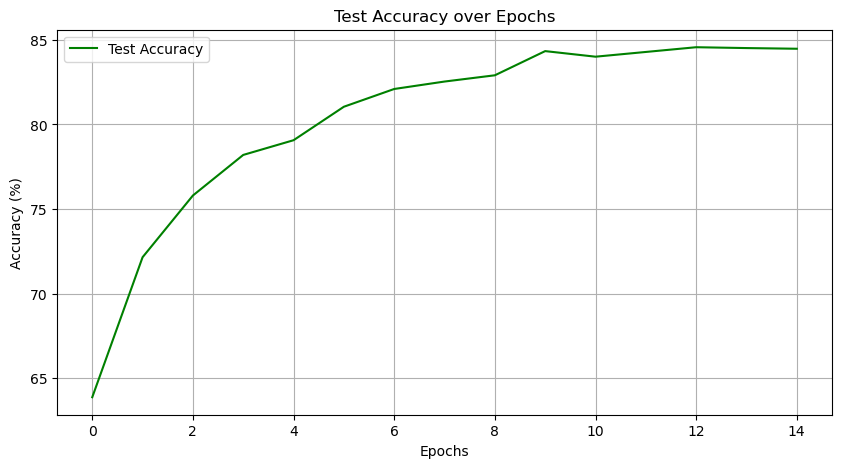

Plots saved as 'plot_assignment2\BigCNN Augmented CosineAnnealingLR_loss.png' and 'plot_assignment2\BigCNN Augmented CosineAnnealingLR_accuracy.png'.

Training Complete!
Total Training Time: 286.47 seconds
Minimum Training Loss: 0.1120
Minimum Test Loss: 0.5156
Highest Test Accuracy: 84.57%


TypeError: class_accuracy() missing 1 required positional argument: 'classes'

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.nn as nn
import torch.nn.functional as F

class BigCNN(nn.Module):
    def __init__(self):
        super(BigCNN, self).__init__()
        
        # Block 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.25)
        
        # Block 2
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.25)
        
        # Fully Connected Layers
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)  # 10 output classes for CIFAR-10

        self.dropout_fc = nn.Dropout(0.5)

    def forward(self, x):
        # Block 1
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.bn1(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        
        # Block 2
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.bn2(x)
        x = self.pool2(x)
        x = self.dropout2(x)

        # Flatten
        x = x.view(x.size(0), -1)  # Flatten the tensor before fully connected layers

        # Fully Connected Layers
        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # No activation here, as it's passed to CrossEntropyLoss

        return x


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

net = BigCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), 0.01, momentum=0.9,weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15)
plot_training(net,optimizer=optimizer,trainloader=trainloader,testloader=testloader,criterion=criterion,scheduler=scheduler,epochs=15,title='BigCNN Augmented CosineAnnealingLR')
class_accuracy(net,  testloader,classes=classes)
plot_class_accuracy_with_confusion_matrix(net, testloader, classes)

Accuracy for class: plane is 88.1 %
Accuracy for class: car   is 91.5 %
Accuracy for class: bird  is 75.0 %
Accuracy for class: cat   is 68.1 %
Accuracy for class: deer  is 83.1 %
Accuracy for class: dog   is 77.7 %
Accuracy for class: frog  is 90.1 %
Accuracy for class: horse is 86.8 %
Accuracy for class: ship  is 92.5 %
Accuracy for class: truck is 91.9 %
Accuracy for class: plane is 88.1 %
Accuracy for class: car   is 91.5 %
Accuracy for class: bird  is 75.0 %
Accuracy for class: cat   is 68.1 %
Accuracy for class: deer  is 83.1 %
Accuracy for class: dog   is 77.7 %
Accuracy for class: frog  is 90.1 %
Accuracy for class: horse is 86.8 %
Accuracy for class: ship  is 92.5 %
Accuracy for class: truck is 91.9 %


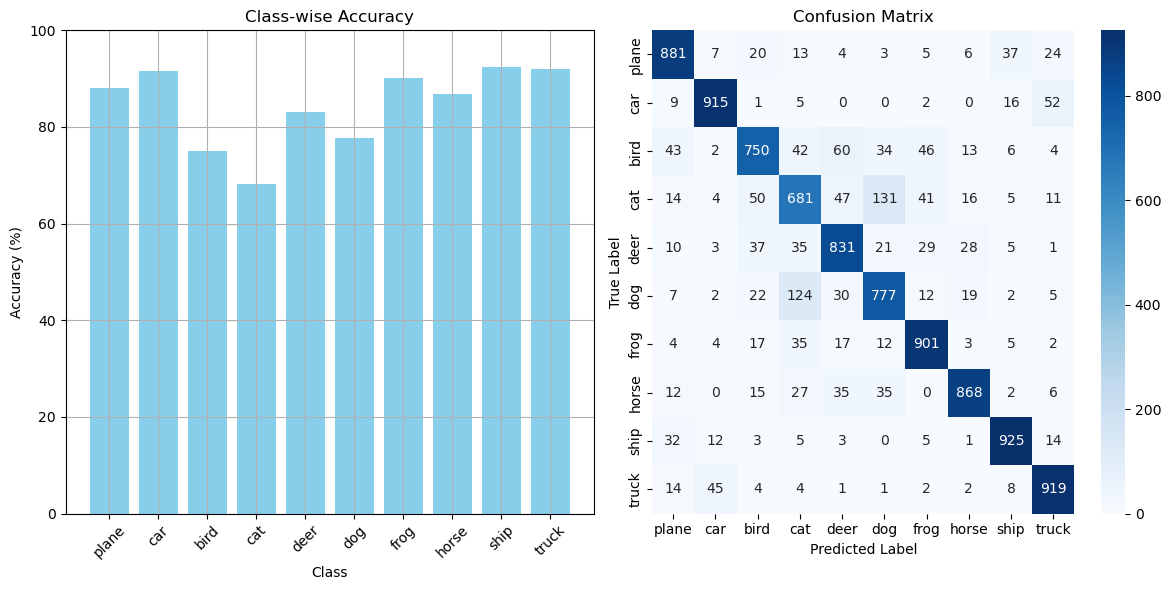

In [7]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



class_accuracy(net,  testloader,classes=classes)
plot_class_accuracy_with_confusion_matrix(net, testloader, classes)

# Resnet Pretrained Augmented CosineAnnealiang

c:\Users\sangi\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sangi\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/15
Accuracy of the network on the test images: 74.37%
Average Test Loss: 0.7461
Train Loss: 1.2659, Test Loss: 0.7461, Accuracy: 74.37%, Time: 20.43s
Epoch 2/15
Accuracy of the network on the test images: 78.18%
Average Test Loss: 0.6379
Train Loss: 0.6806, Test Loss: 0.6379, Accuracy: 78.18%, Time: 19.80s
Epoch 3/15
Accuracy of the network on the test images: 79.41%
Average Test Loss: 0.6090
Train Loss: 0.5307, Test Loss: 0.6090, Accuracy: 79.41%, Time: 19.80s
Epoch 4/15
Accuracy of the network on the test images: 80.15%
Average Test Loss: 0.6026
Train Loss: 0.4253, Test Loss: 0.6026, Accuracy: 80.15%, Time: 19.81s
Epoch 5/15
Accuracy of the network on the test images: 80.38%
Average Test Loss: 0.6188
Train Loss: 0.3261, Test Loss: 0.6188, Accuracy: 80.38%, Time: 19.96s
Epoch 6/15
Accuracy of the network on the test images: 80.44%
Average Test Loss: 0.6524
Train Loss: 0.2559, Test Loss: 0.6524, Accuracy: 80.44%, Time: 19.40s
Epoch 7/15
Accuracy of the network on the test image

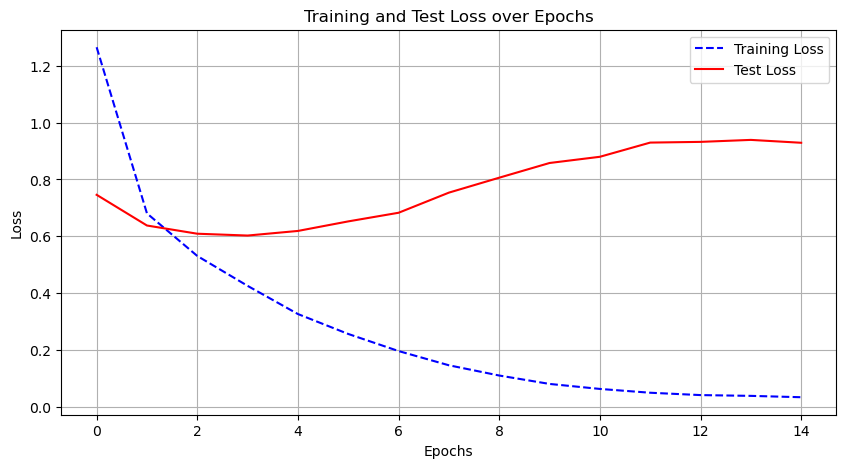

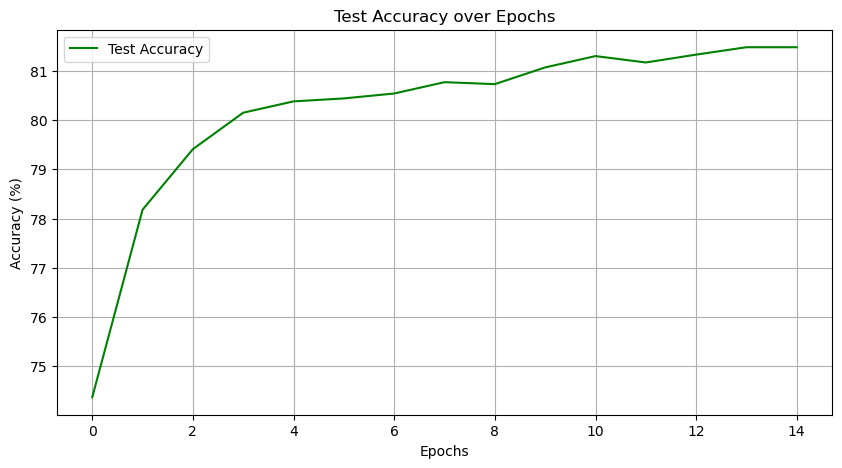

Plots saved as 'plot_assignment2\Resnet Pretrained Augmented CosineAnnealiang_loss.png' and 'plot_assignment2\Resnet Pretrained Augmented CosineAnnealiang_accuracy.png'.

Training Complete!
Total Training Time: 309.40 seconds
Minimum Training Loss: 0.0331
Minimum Test Loss: 0.6026
Highest Test Accuracy: 81.48%
Accuracy for class: plane is 85.7 %
Accuracy for class: car   is 90.4 %
Accuracy for class: bird  is 72.3 %
Accuracy for class: cat   is 64.4 %
Accuracy for class: deer  is 83.0 %
Accuracy for class: dog   is 70.9 %
Accuracy for class: frog  is 86.8 %
Accuracy for class: horse is 83.9 %
Accuracy for class: ship  is 90.7 %
Accuracy for class: truck is 86.7 %
Accuracy for class: plane is 85.7 %
Accuracy for class: car   is 90.4 %
Accuracy for class: bird  is 72.3 %
Accuracy for class: cat   is 64.4 %
Accuracy for class: deer  is 83.0 %
Accuracy for class: dog   is 70.9 %
Accuracy for class: frog  is 86.8 %
Accuracy for class: horse is 83.9 %
Accuracy for class: ship  is 90.7 %
Accu

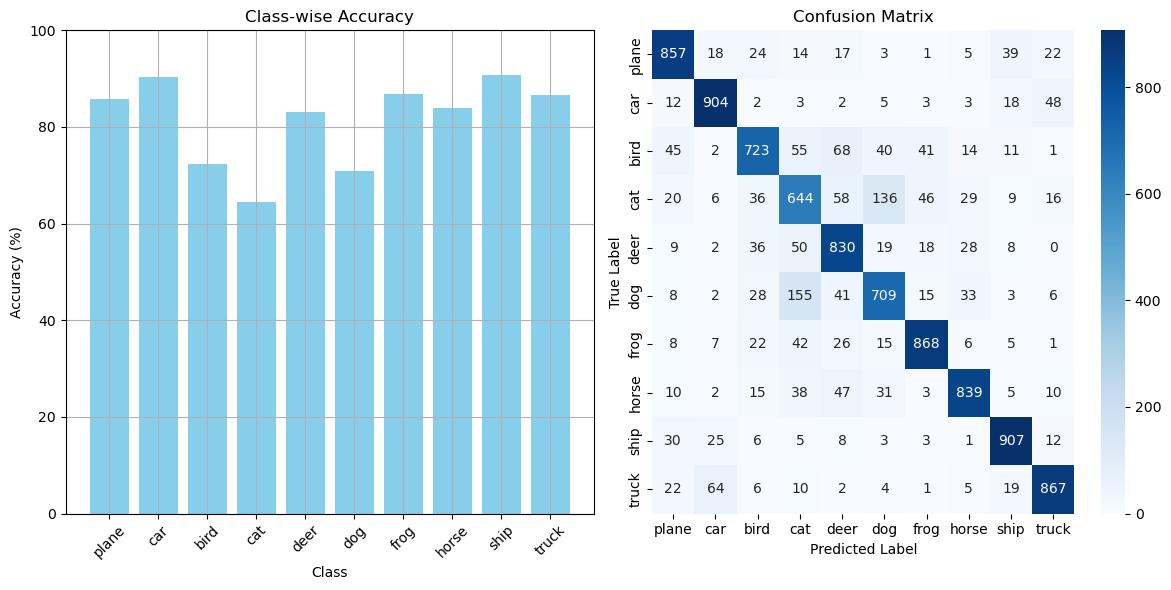

In [8]:
import torchvision.models as models

net = models.resnet18(pretrained=True)

net = net.to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epoch)
criterion = nn.CrossEntropyLoss()
plot_training(net, trainloader=trainloader, testloader=testloader, epochs=15, optimizer=optimizer, scheduler=scheduler, criterion=criterion,title='Resnet Pretrained Augmented CosineAnnealiang')
class_accuracy(net,  testloader,classes=classes)
plot_class_accuracy_with_confusion_matrix(net, testloader, classes)

# Resnet18 Augmented CosineAnnealing Fine Tunined L4 & FC

Epoch 1/15
Accuracy of the network on the test images: 53.95%
Average Test Loss: 1.2977
Train Loss: 1.5032, Test Loss: 1.2977, Accuracy: 53.95%, Time: 21.51s
Epoch 2/15
Accuracy of the network on the test images: 57.43%
Average Test Loss: 1.1932
Train Loss: 1.2372, Test Loss: 1.1932, Accuracy: 57.43%, Time: 21.03s
Epoch 3/15
Accuracy of the network on the test images: 60.09%
Average Test Loss: 1.1544
Train Loss: 1.1531, Test Loss: 1.1544, Accuracy: 60.09%, Time: 21.13s
Epoch 4/15
Accuracy of the network on the test images: 62.16%
Average Test Loss: 1.0801
Train Loss: 1.1009, Test Loss: 1.0801, Accuracy: 62.16%, Time: 21.21s
Epoch 5/15
Accuracy of the network on the test images: 63.06%
Average Test Loss: 1.0378
Train Loss: 1.0583, Test Loss: 1.0378, Accuracy: 63.06%, Time: 20.79s
Epoch 6/15
Accuracy of the network on the test images: 64.26%
Average Test Loss: 1.0222
Train Loss: 1.0313, Test Loss: 1.0222, Accuracy: 64.26%, Time: 21.20s
Epoch 7/15
Accuracy of the network on the test image

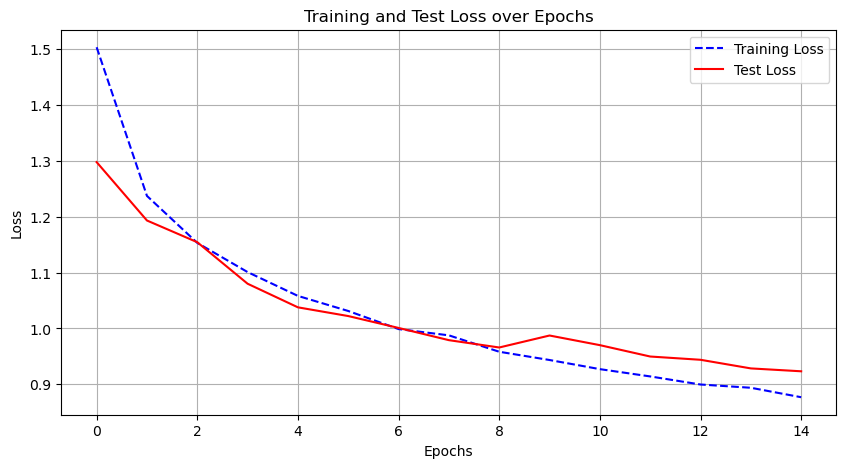

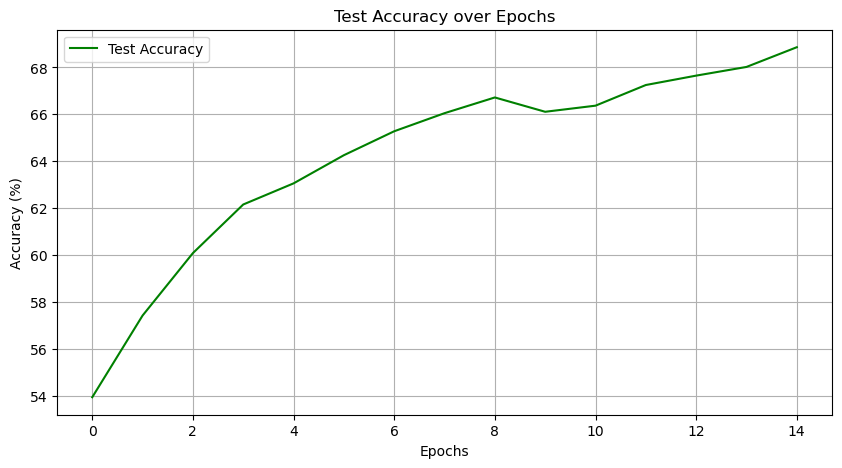

Plots saved as 'plot_assignment2\Resnet18 Augmented CosineAnnealing Fine Tunined L4 & FC_loss.png' and 'plot_assignment2\Resnet18 Augmented CosineAnnealing Fine Tunined L4 & FC_accuracy.png'.

Training Complete!
Total Training Time: 317.87 seconds
Minimum Training Loss: 0.8770
Minimum Test Loss: 0.9234
Highest Test Accuracy: 68.86%
Accuracy for class: plane is 72.8 %
Accuracy for class: car   is 73.8 %
Accuracy for class: bird  is 64.5 %
Accuracy for class: cat   is 49.9 %
Accuracy for class: deer  is 65.9 %
Accuracy for class: dog   is 57.9 %
Accuracy for class: frog  is 80.4 %
Accuracy for class: horse is 72.9 %
Accuracy for class: ship  is 79.5 %
Accuracy for class: truck is 71.0 %


In [ ]:
import torchvision.models as models

net = models.resnet18(pretrained=True)
for param in net.parameters():
    param.requires_grad = False
net.fc = nn.Linear(net.fc.in_features, 10)
for param in net.layer4.parameters():
    param.requires_grad = True
net = net.to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epoch)
criterion = nn.CrossEntropyLoss()
plot_training(net, trainloader=trainloader, testloader=testloader, epochs=15, optimizer=optimizer, criterion=criterion,title='Resnet18 Augmented CosineAnnealing Fine Tunined L4 & FC')
class_accuracy(net, testloader)


Now use it to train the your model

## Exercise 3
A) Try to change the network architecture (e.g. use all linear layers) or network hyperparameters (e.g. dimensions of the CNN kernel, stride, padding).

B) Try also to compare performance of your model with performance of pre-defined network architecture.
There are a lot of pre-defined network architectures (e.g. ResNet, VGG, AlexNet, ...).

Some example can be found in https://pytorch.org/vision/0.9/models.html.

Specific CIFAR10 architectures are also in this public repository https://github.com/kuangliu/pytorch-cifar.

In [ ]:
import torchvision.models as models

alexnet = models.alexnet()
resnet18 = models.resnet18()
vgg16 = models.vgg16()

alexnet.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

# look at documentation: https://www.kaggle.com/code/datastrophy/vgg16-pytorch-implementation

Epoch 1/15
Accuracy of the network on the test images: 27.85%
Average Test Loss: 1.8747
Train Loss: 2.5006, Test Loss: 1.8747, Accuracy: 27.85%, Time: 46.88s
Epoch 2/15
Accuracy of the network on the test images: 39.02%
Average Test Loss: 1.6432
Train Loss: 1.8271, Test Loss: 1.6432, Accuracy: 39.02%, Time: 46.72s
Epoch 3/15
Accuracy of the network on the test images: 45.86%
Average Test Loss: 1.4472
Train Loss: 1.6041, Test Loss: 1.4472, Accuracy: 45.86%, Time: 48.38s
Epoch 4/15
Accuracy of the network on the test images: 53.56%
Average Test Loss: 1.2988
Train Loss: 1.3913, Test Loss: 1.2988, Accuracy: 53.56%, Time: 48.36s
Epoch 5/15
Accuracy of the network on the test images: 61.89%
Average Test Loss: 1.0695
Train Loss: 1.2063, Test Loss: 1.0695, Accuracy: 61.89%, Time: 48.49s
Epoch 6/15
Accuracy of the network on the test images: 66.38%
Average Test Loss: 0.9521
Train Loss: 1.0374, Test Loss: 0.9521, Accuracy: 66.38%, Time: 48.47s
Epoch 7/15
Accuracy of the network on the test image

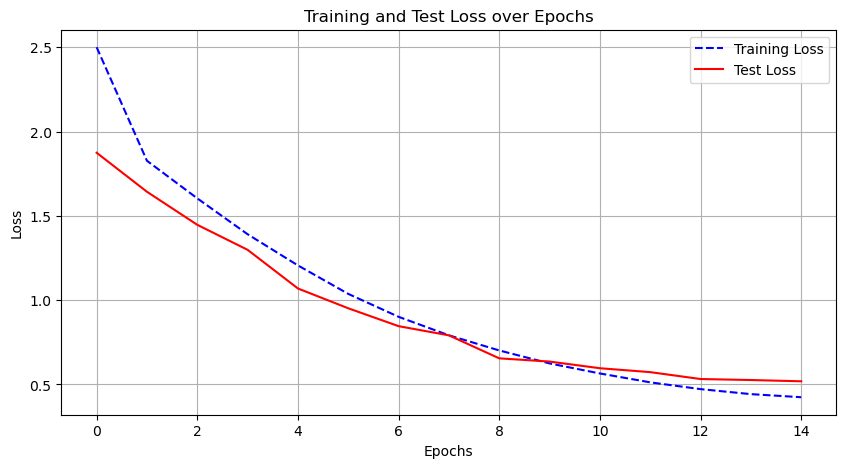

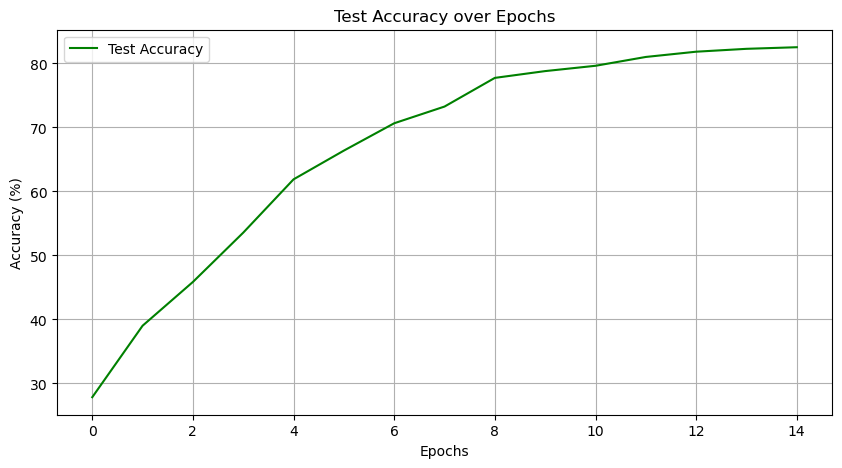

Plots saved as 'plot_assignment2\VGG16 Augmented CosineAnnealing Fine Tunined L4 & FC_loss.png' and 'plot_assignment2\VGG16 Augmented CosineAnnealing Fine Tunined L4 & FC_accuracy.png'.

Training Complete!
Total Training Time: 719.33 seconds
Minimum Training Loss: 0.4244
Minimum Test Loss: 0.5190
Highest Test Accuracy: 82.53%
Accuracy for class: plane is 87.0 %
Accuracy for class: car   is 93.0 %
Accuracy for class: bird  is 71.5 %
Accuracy for class: cat   is 64.3 %
Accuracy for class: deer  is 82.1 %
Accuracy for class: dog   is 75.0 %
Accuracy for class: frog  is 87.8 %
Accuracy for class: horse is 85.2 %
Accuracy for class: ship  is 90.3 %
Accuracy for class: truck is 89.1 %


In [ ]:
vgg16.fc = nn.Linear(4096, 10)
net = vgg16.to(device)
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epoch)
criterion = nn.CrossEntropyLoss()
plot_training(net, trainloader=trainloader, testloader=testloader,scheduler=scheduler, epochs=15, optimizer=optimizer, criterion=criterion,title='VGG16 Augmented CosineAnnealing Fine Tunined L4 & FC')
class_accuracy(net, testloader)

# look at the documentation: https://github.com/rasbt/deeplearning-models/blob/master/pytorch_ipynb/cnn/cnn-alexnet-cifar10.ipynb

Epoch 1/15
Accuracy of the network on the test images: 25.98%
Average Test Loss: 1.8529
Train Loss: 2.2017, Test Loss: 1.8529, Accuracy: 25.98%, Time: 22.02s
Epoch 2/15
Accuracy of the network on the test images: 44.59%
Average Test Loss: 1.5055
Train Loss: 1.6456, Test Loss: 1.5055, Accuracy: 44.59%, Time: 21.59s
Epoch 3/15
Accuracy of the network on the test images: 54.51%
Average Test Loss: 1.2737
Train Loss: 1.3580, Test Loss: 1.2737, Accuracy: 54.51%, Time: 21.24s
Epoch 4/15
Accuracy of the network on the test images: 58.31%
Average Test Loss: 1.1665
Train Loss: 1.1659, Test Loss: 1.1665, Accuracy: 58.31%, Time: 21.34s
Epoch 5/15
Accuracy of the network on the test images: 59.18%
Average Test Loss: 1.1562
Train Loss: 1.0247, Test Loss: 1.1562, Accuracy: 59.18%, Time: 21.41s
Epoch 6/15
Accuracy of the network on the test images: 62.94%
Average Test Loss: 1.0784
Train Loss: 0.8946, Test Loss: 1.0784, Accuracy: 62.94%, Time: 21.24s
Epoch 7/15
Accuracy of the network on the test image

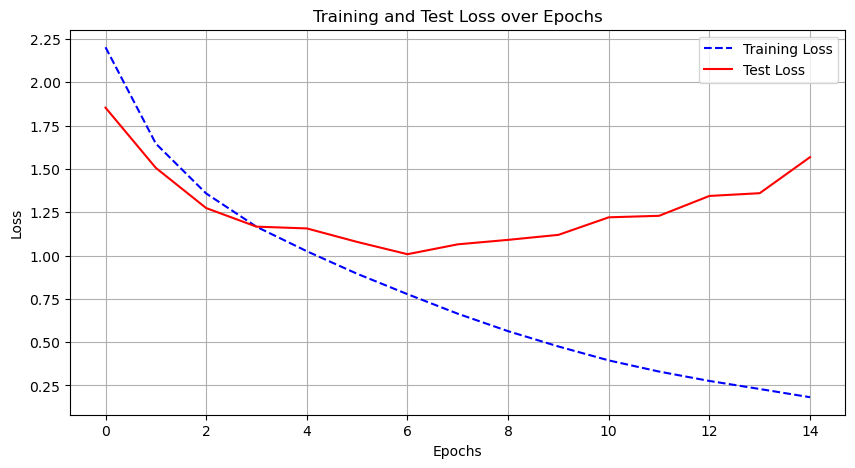

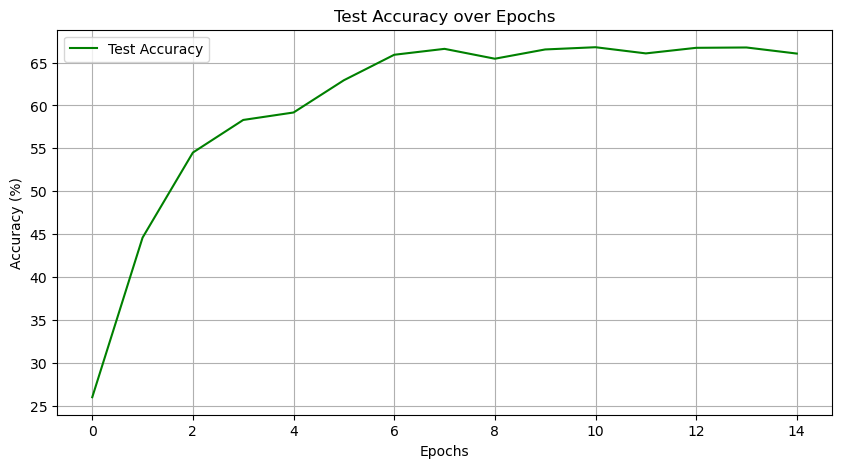

Plots saved as 'plot_assignment2\Alexnet Augmented CosineAnnealing Fine Tunined L4 & FC_loss.png' and 'plot_assignment2\Alexnet Augmented CosineAnnealing Fine Tunined L4 & FC_accuracy.png'.

Training Complete!
Total Training Time: 321.35 seconds
Minimum Training Loss: 0.1824
Minimum Test Loss: 1.0075
Highest Test Accuracy: 66.79%
Accuracy for class: plane is 83.9 %
Accuracy for class: car   is 82.7 %
Accuracy for class: bird  is 61.2 %
Accuracy for class: cat   is 46.8 %
Accuracy for class: deer  is 61.7 %
Accuracy for class: dog   is 45.8 %
Accuracy for class: frog  is 76.4 %
Accuracy for class: horse is 64.9 %
Accuracy for class: ship  is 69.4 %
Accuracy for class: truck is 67.7 %


In [ ]:
alexnet.features[2] = nn.Identity()
alexnet.to(device)
optimizer = optim.SGD(alexnet.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epoch)
criterion = nn.CrossEntropyLoss()
plot_training(alexnet, trainloader=trainloader, testloader=testloader, epochs=15, optimizer=optimizer, criterion=criterion,title='Alexnet CosineAnnealing')
class_accuracy(alexnet, testloader)

c:\Users\sangi\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sangi\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/15
Accuracy of the network on the test images: 56.96%
Average Test Loss: 1.1993
Train Loss: 1.7402, Test Loss: 1.1993, Accuracy: 56.96%, Time: 23.99s
Epoch 2/15
Accuracy of the network on the test images: 64.26%
Average Test Loss: 1.0125
Train Loss: 1.1532, Test Loss: 1.0125, Accuracy: 64.26%, Time: 23.79s
Epoch 3/15
Accuracy of the network on the test images: 68.84%
Average Test Loss: 0.9073
Train Loss: 1.0152, Test Loss: 0.9073, Accuracy: 68.84%, Time: 24.69s
Epoch 4/15
Accuracy of the network on the test images: 71.06%
Average Test Loss: 0.8318
Train Loss: 0.9192, Test Loss: 0.8318, Accuracy: 71.06%, Time: 25.27s
Epoch 5/15
Accuracy of the network on the test images: 72.07%
Average Test Loss: 0.8301
Train Loss: 0.8487, Test Loss: 0.8301, Accuracy: 72.07%, Time: 24.02s
Epoch 6/15
Accuracy of the network on the test images: 72.65%
Average Test Loss: 0.8032
Train Loss: 0.7951, Test Loss: 0.8032, Accuracy: 72.65%, Time: 23.76s
Epoch 7/15
Accuracy of the network on the test image

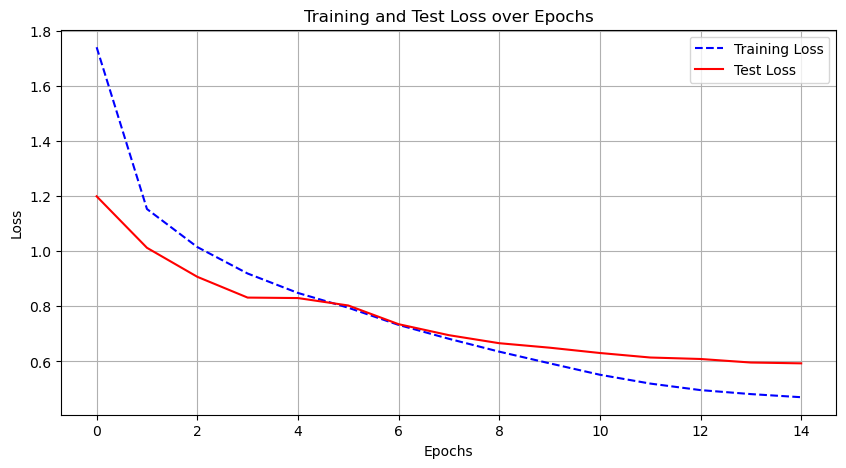

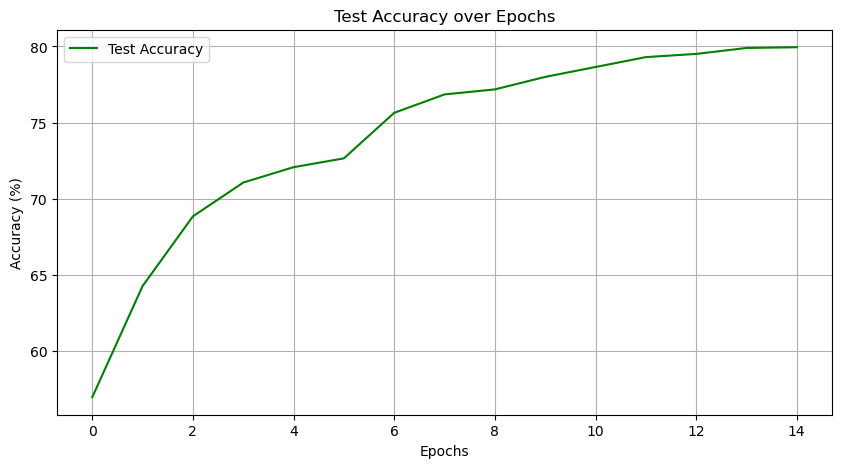

Plots saved as 'plot_assignment2\Alexnet Augmented CosineAnnealing Fine Tunined L4 & FC_loss.png' and 'plot_assignment2\Alexnet Augmented CosineAnnealing Fine Tunined L4 & FC_accuracy.png'.

Training Complete!
Total Training Time: 391.08 seconds
Minimum Training Loss: 0.4703
Minimum Test Loss: 0.5933
Highest Test Accuracy: 79.95%
Accuracy for class: plane is 86.7 %
Accuracy for class: car   is 87.6 %
Accuracy for class: bird  is 72.2 %
Accuracy for class: cat   is 62.0 %
Accuracy for class: deer  is 76.9 %
Accuracy for class: dog   is 69.6 %
Accuracy for class: frog  is 87.8 %
Accuracy for class: horse is 82.0 %
Accuracy for class: ship  is 87.9 %
Accuracy for class: truck is 86.8 %


In [ ]:
alexnet = models.alexnet(pretrained=True)
alexnet.features[2] = nn.Identity()
alexnet.to(device)
optimizer = optim.SGD(alexnet.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epoch)
criterion = nn.CrossEntropyLoss()
plot_training(alexnet, trainloader=trainloader, scheduler=scheduler, testloader=testloader, epochs=15, optimizer=optimizer, criterion=criterion,title='Alexnet Augmented CosineAnnealing Fine Tunined L4 & FC')
class_accuracy(alexnet, testloader)